## Decision Trees

Decision Trees algorithm can be used to solve both regression and classification tasks.

Structure of decision trees:

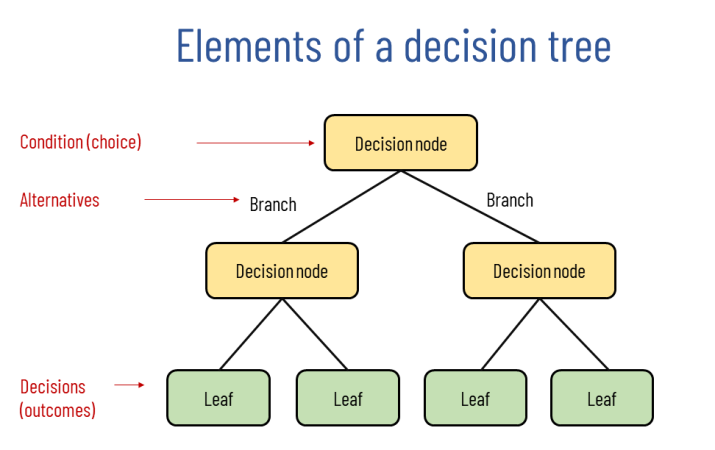

<b>Root node</b>: Starting point of decision trees

<b>Decision node</b>: Intermediate points of decision trees after node splitting

<b>Leaf node</b>: End points of decision trees, where nodes could not be split further

Note that decision tree is considered as a greedy algorithm built in top-down recursive or divide-and-conquer manner, which is very prone to model overfitting

<b>Assumptions of Decision Tree</b>:
1. Whole training set is considered as root at start of model training
2. Feature values are categorical. If continuous, then they are discretized into thresholds before model training.
3. Records are distributed recursively on the basis of feature values.
4. Order to placing attributes as root or decision node of the tree is done by using some statistical approach

<b>Requirement of feature scaling: No</b>

<b>Robust to outliers: Yes</b>

<b>Is multicollinearity an issue?: No</b>

<b>Advantages of Decision Trees</b>:
1. Can solve both regression and classification tasks
2. Rules of splitting clearly mentioned
3. Decision tree can be visualized for easy understanding
4. Feature scaling not required
5. Not sensitive to outliers
6. Model performance not impacted by missing values

<b>Disadvantages of Decision Trees</b>:
1. Small changes in training data causes model instability
2. High probability of model overfitting without tree pruning
3. Longer time needed for model training
4. Creates biased trees if some target classes dominate. 

<b>Time complexity of model training: O(n*log(n)*p)</b>

<b>Time complexity of model prediction: O(d)</b>

<b>Space complexity of model prediction: O(k)</b> 

n - Number of training samples

p - Number of features

d - Maximum depth of tree

k - Number of nodes in tree

## Pruning for Decision Tree

Tree pruning is the method of trimming down a full decision tree to reduce the complexity and variance in the data.

Two methods of tree pruning:
1. <b>Post-pruning</b>: Complete decision tree is generated first and then non-significant branches are removed if any improvements are identified by using cross validation methods.

2. <b>Pre-pruning</b>: Condition is used to decide when to terminate node split prematurely as decision tree is generated.

Post-pruning is the most preferred method for pruning tree-based algorithms in exchange for higher computational cost using <b>ccp_alpha</b> hyperparameter.

Most important hyperparameters for pre-pruning tree based algorithms:
1. <b>min_samples_split</b>: Best values to test are between 1 and 40
2. <b>min_samples_leaf</b>: Best values to test are between 1 and 20

In [1]:
# Import all required Python libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, load_wine
from skopt import BayesSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from skopt.space import Real, Integer, Categorical
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
from sklearn import tree

More details related to Exploratory Data Analysis for both regression and classification problem statement can be found in the following Jupyter Notebook within the same folder: EDA_Regression.ipynb and EDA_Classification.ipynb

## Decision Tree for regression

For regression tasks, features are divided into distinct and non-overlapping regions, where observations within the region are predicted as the average of target values.

<b>Important hyperparameters for DecisionTreeRegressor</b>:
- Post Pruning (Most preferable)
1. ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.
2. criterion: Function used to measure quality of split ('squared_error', 'friedman_mse', 'absolute_error', 'poisson')

- Pre Pruning
1. max_depth: Maximum depth of decision tree
2. min_samples_split: Minimum number of samples required to split internal nodes
3. min_samples_leaf: Minimum number of samples required for leaf nodes
4. max_features: Number of features to consider when looking for splits

In [2]:
data = fetch_california_housing()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Median House Value ($100000)'

In [3]:
clf = DecisionTreeRegressor(random_state=120)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas

100%|██████████| 50/50 [01:45<00:00,  2.10s/it]


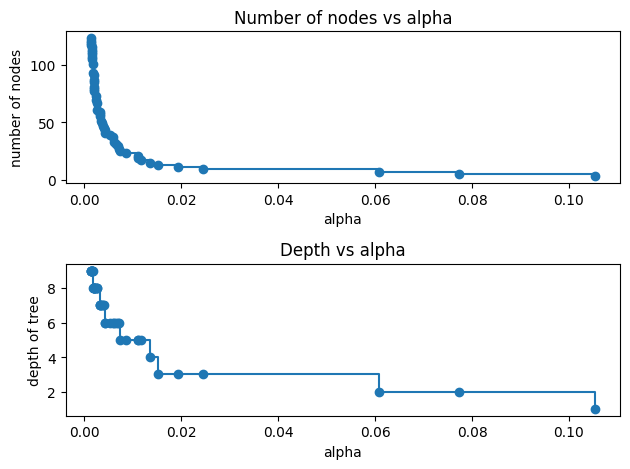

In [4]:
clfs = []
for ccp_alpha in tqdm(path.ccp_alphas[-50:]):
    clf = DecisionTreeRegressor(random_state=120, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)
    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[-50:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [5]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = KFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_rmse, test_rmse = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,
                               scoring= make_scorer(mean_squared_error, squared=False),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_rmse.append(search.best_score_)
        print(f'Validation RMSE for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_rmse.append(mean_squared_error(y_test,y_pred,squared=False))
        print(f'Test RMSE for fold {fold+1}:',mean_squared_error(y_test,y_pred,squared=False))
        plt.figure(figsize=(6,4))
        features = X_test.columns
        tree.plot_tree(search.best_estimator_[-1],feature_names=features,filled=True,max_depth=3, fontsize=5)
        plt.tight_layout()
        plt.show()
        print()
    print('----------------------')
    print('Average validation RMSE score:', np.mean(val_rmse))
    print('Average test RMSE score:', np.mean(test_rmse))

Validation RMSE for fold 1: 0.8566569916995986
Best hyperparameters for fold 1: OrderedDict([('regression__ccp_alpha', 0.008691870974828667), ('regression__criterion', 'poisson')])
Test RMSE for fold 1: 0.8246169572402026


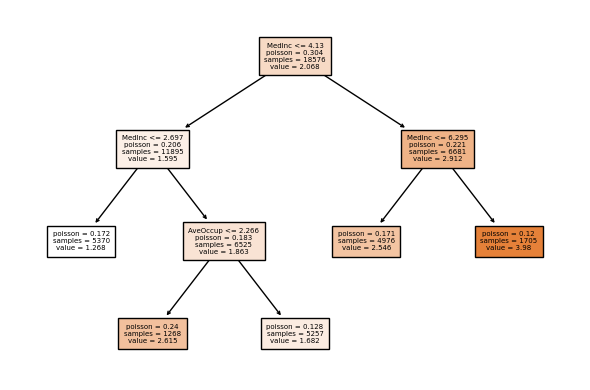


Validation RMSE for fold 2: 0.9864462140944404
Best hyperparameters for fold 2: OrderedDict([('regression__ccp_alpha', 0.0774113353608363), ('regression__criterion', 'poisson')])
Test RMSE for fold 2: 0.9730029061329656


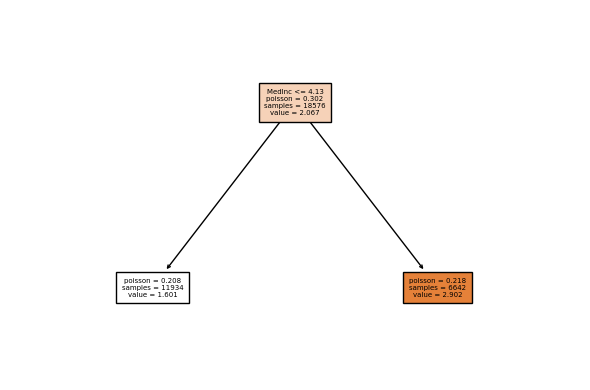


Validation RMSE for fold 3: 0.88561962791355
Best hyperparameters for fold 3: OrderedDict([('regression__ccp_alpha', 0.0192990588977332), ('regression__criterion', 'absolute_error')])
Test RMSE for fold 3: 0.8948379123447311


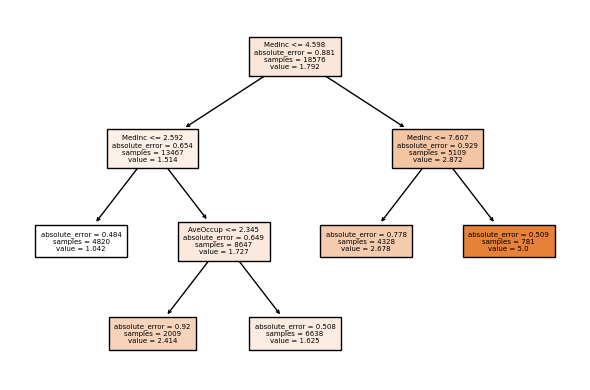


Validation RMSE for fold 4: 0.8515564311550852
Best hyperparameters for fold 4: OrderedDict([('regression__ccp_alpha', 0.011674587531873198), ('regression__criterion', 'absolute_error')])
Test RMSE for fold 4: 0.8123987719825467


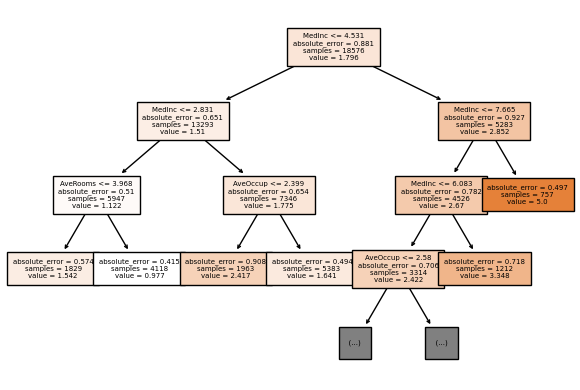


Validation RMSE for fold 5: 0.8840832015906193
Best hyperparameters for fold 5: OrderedDict([('regression__ccp_alpha', 0.06075385283365936), ('regression__criterion', 'friedman_mse')])
Test RMSE for fold 5: 0.8750071121242188


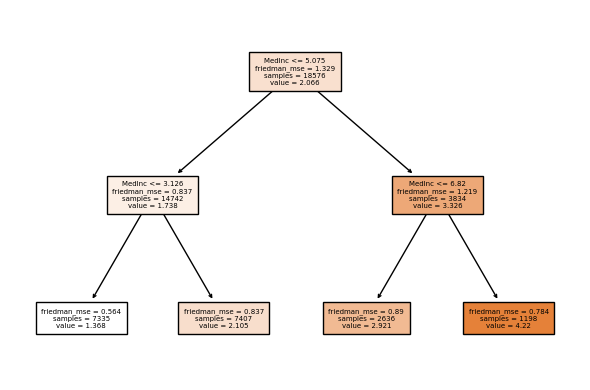


Validation RMSE for fold 6: 0.9860714592505065
Best hyperparameters for fold 6: OrderedDict([('regression__ccp_alpha', 0.0774113353608363), ('regression__criterion', 'poisson')])
Test RMSE for fold 6: 0.9563182158578717


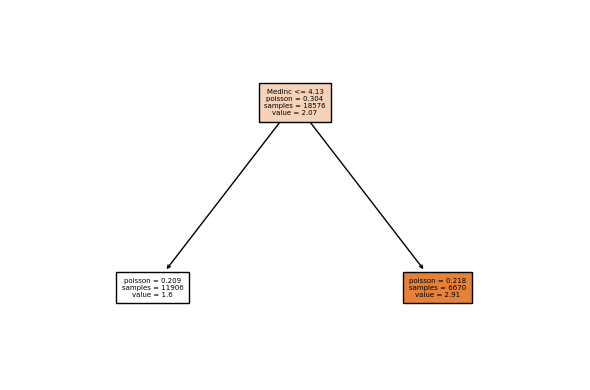


Validation RMSE for fold 7: 0.8617982137290285
Best hyperparameters for fold 7: OrderedDict([('regression__ccp_alpha', 0.011150264573998939), ('regression__criterion', 'poisson')])
Test RMSE for fold 7: 0.8484253101166997


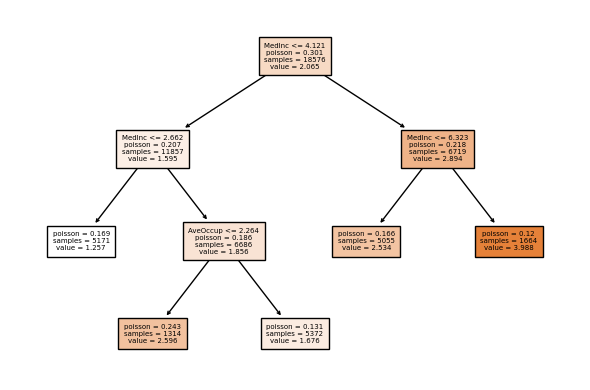


Validation RMSE for fold 8: 0.8503389665537252
Best hyperparameters for fold 8: OrderedDict([('regression__ccp_alpha', 0.011674587531873198), ('regression__criterion', 'poisson')])
Test RMSE for fold 8: 0.8350904060775107


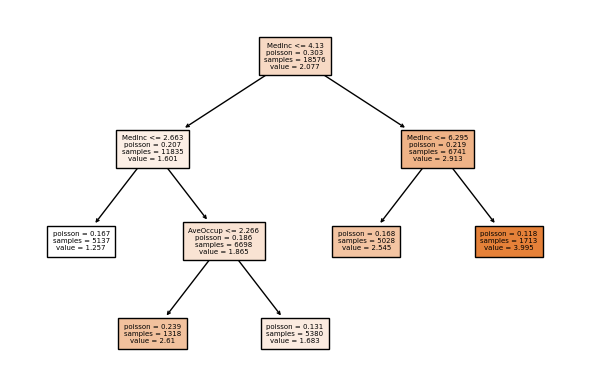


Validation RMSE for fold 9: 0.8508245962420512
Best hyperparameters for fold 9: OrderedDict([('regression__ccp_alpha', 0.011063560866431565), ('regression__criterion', 'absolute_error')])
Test RMSE for fold 9: 0.7884267148343813


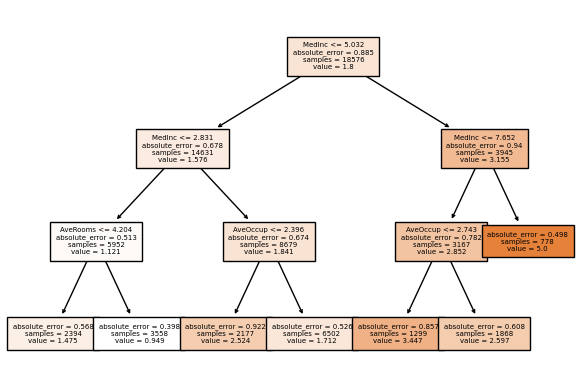


Validation RMSE for fold 10: 0.9016180893335278
Best hyperparameters for fold 10: OrderedDict([('regression__ccp_alpha', 0.0774113353608363), ('regression__criterion', 'friedman_mse')])
Test RMSE for fold 10: 0.895289081907284


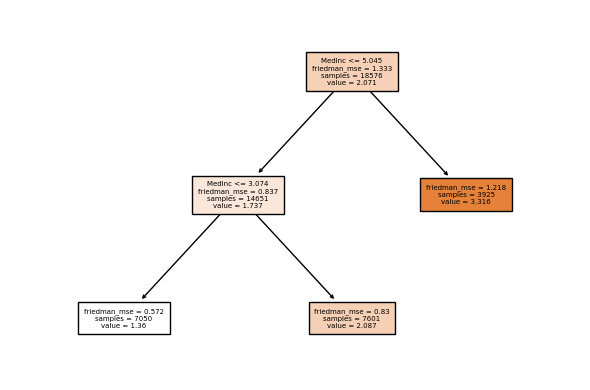


----------------------
Average validation RMSE score: 0.8915013791562133
Average test RMSE score: 0.8703413388618413


In [6]:
reg = DecisionTreeRegressor(random_state=120)
pipeline = Pipeline(steps=[])
pipeline.steps.append(('regression',reg))
search_space = dict()
search_space['regression__ccp_alpha'] = Categorical(ccp_alphas)
search_space['regression__criterion'] = Categorical(['squared_error', 'friedman_mse', 'absolute_error', 'poisson'])
nested_cv(X, y, pipeline, search_space)

## Decision Tree for Classification

For classification tasks, features are divided into distinct and non-overlapping regions, where observations within the region are predicted as target class based on maximum votes.

<b>Important hyperparameters for DecisionTreeClassifier</b>:
- Post Pruning (Most preferable)
1. ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen.
2. criterion: Function used to measure quality of split ('squared_error', 'friedman_mse', 'absolute_error', 'poisson')
3. class_weight: Weights associated with target classes

- Pre Pruning
1. max_depth: Maximum depth of decision tree
2. min_samples_split: Minimum number of samples required to split internal nodes
3. min_samples_leaf: Minimum number of samples required for leaf nodes
4. max_features: Number of features to consider when looking for splits

<b>Methods to handle imbalanced dataset for classification</b>:
1. Assign class weights to model
2. Resampling techniques (Oversampling/Combination of Oversampling and Undersampling - Less suitable for larger datasets due to high computation time)

Since order of feature splits can be arranged in many different orders, the optimum decision tree that provides the best model performance is determined based on these main concepts:

- Entropy and Information Gain
- Gini Impurity Index

Note that scikit-learn library uses <b>CART (Classification and Regression Trees)</b> algorithm to determine optimum order of feature splits of decision trees, which uses gini impurity (by default) or entropy.

Other algorithms related to decision trees:
1. ID3 (Iterative Dichotomiser) - Uses information gain as criteria for finding root nodes and it only accepts categorical features.

2. C4.5 - Extension of ID3 algorithm, which accepts both categorical and continuous features

## Entropy and Information Gain

<b>Entropy</b> represents the purity measure of subset splits for specific node in terms of bits <b>between 0 and 1 for binary class</b>.

Formula for entropy at node S before split:

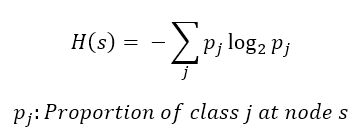

Interpretation of entropy value:

- 1 - Split is impure (equal proportion between classes after split).
- 0 - Split is pure (100% proportion belonging to given class without randomness).

Note that entropy value of 0 bits on leaf nodes is more favourable for decision trees.

<b>Information gain</b> represents the effective change in entropy after selecting a specific feature for data splitting.

Formula for information gain at node S based on split of feature A:

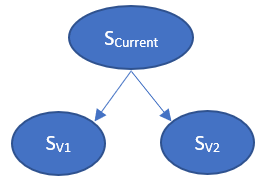

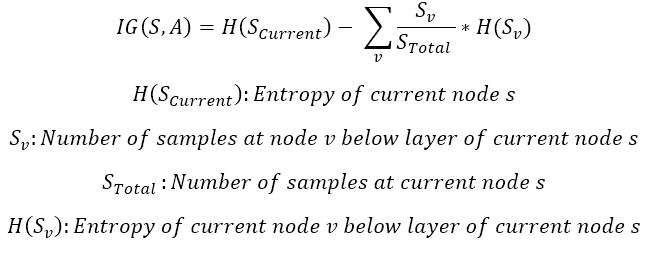

Decision Tree algorithm selects the order of splits that provides the <b>highest information gain</b> at every layer of decision tree.

## Gini Impurity Index

Gini Impurity is the probability of incorrectly classifying an observation, which is another purity measure of subset splits for specific node in terms of bits between 0 and 0.5 for binary class.

Formula of gini impurity at node i:

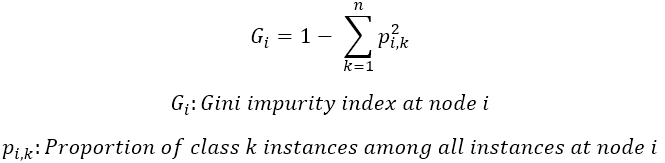

Decision Tree algorithm selects the order of splits that provides the <b>lowest gini impurity index</b> at every layer of decision tree.

Note that gini impurity is more computationally efficient than entropy, since log calculation is not used for calculating gini impurity.

## Decision Tree Splits for Numerical Features

When determining optimum decision tree splits related to numerical features:
- Numerical features sorted in ascending order
- Threshold from specific numerical feature is selected for every value to identify threshold value with best information gain

Note that working with numerical features in decision trees requires very large time training complexity.

In [7]:
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])
y.name = 'Wine_Class'

In [8]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

In [9]:
clf = DecisionTreeClassifier(random_state=120)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas

100%|██████████| 11/11 [00:00<00:00, 255.74it/s]


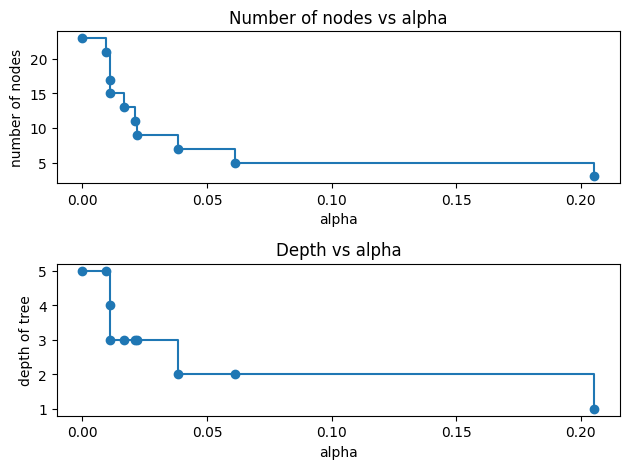

In [10]:
clfs = []
for ccp_alpha in tqdm(ccp_alphas):
    clf = DecisionTreeClassifier(random_state=120, ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)
    
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [11]:
def nested_cv(X, y, pipeline, search_space = None):
    num_folds = 10
    skfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=120)
    val_f1, test_f1 = [], []
    for fold, (outer_train_idx, outer_test_idx) in enumerate(skfold.split(X, y)):
        X_train = X.iloc[outer_train_idx,:].reset_index(drop=True)
        y_train = y.iloc[outer_train_idx].reset_index(drop=True)
        X_test = X.iloc[outer_test_idx,:].reset_index(drop=True)
        y_test = y.iloc[outer_test_idx].reset_index(drop=True)
        search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10,scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
        search.fit(X_train,y_train)
        val_f1.append(search.best_score_)
        print(f'Validation F1 score for fold {fold+1}:',search.best_score_)
        print(f'Best hyperparameters for fold {fold+1}:', search.best_params_)
        y_pred = search.best_estimator_.predict(X_test)
        test_f1.append(f1_score(y_test,y_pred, average='macro'))
        print(f'Test F1 score for fold {fold+1}:',f1_score(y_test,y_pred, average='macro'))
        print()
        cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        cmd.ax_.set_title(f"Confusion Matrix - DecisionTreeClassifier (Fold {fold+1})")
        plt.grid(False)
        plt.show()
        print()
    print('----------------------')
    print('Average validation F1 score:', np.mean(val_f1))
    print('Average test F1 score:', np.mean(test_f1))

Validation F1 score for fold 1: 0.937220167281638
Best hyperparameters for fold 1: OrderedDict([('classification__ccp_alpha', 0.010879258070269298), ('classification__criterion', 'gini')])
Test F1 score for fold 1: 0.9407407407407408



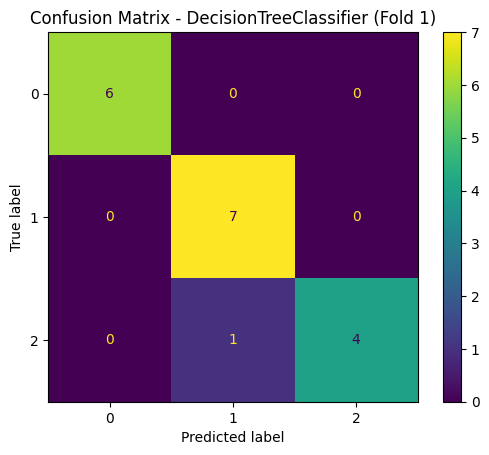


Validation F1 score for fold 2: 0.8999275803888807
Best hyperparameters for fold 2: OrderedDict([('classification__ccp_alpha', 0.06105020507820828), ('classification__criterion', 'entropy')])
Test F1 score for fold 2: 1.0



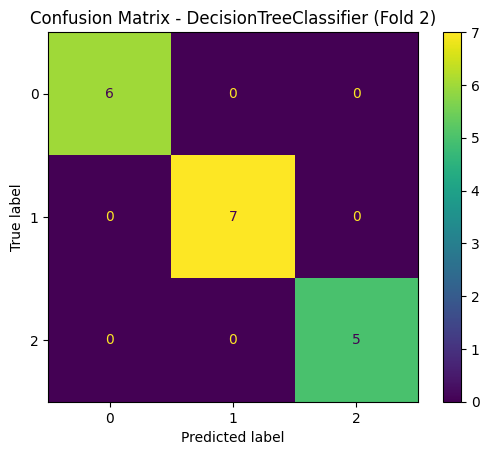


Validation F1 score for fold 3: 0.9135960690155962
Best hyperparameters for fold 3: OrderedDict([('classification__ccp_alpha', 0.02171015044753381), ('classification__criterion', 'gini')])
Test F1 score for fold 3: 0.9407407407407408



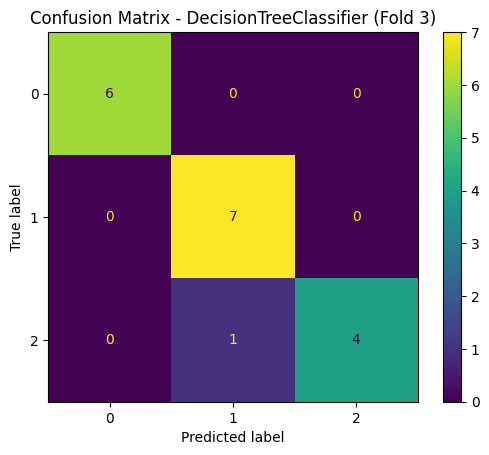


Validation F1 score for fold 4: 0.896954410494142
Best hyperparameters for fold 4: OrderedDict([('classification__ccp_alpha', 0.02171015044753381), ('classification__criterion', 'gini')])
Test F1 score for fold 4: 1.0



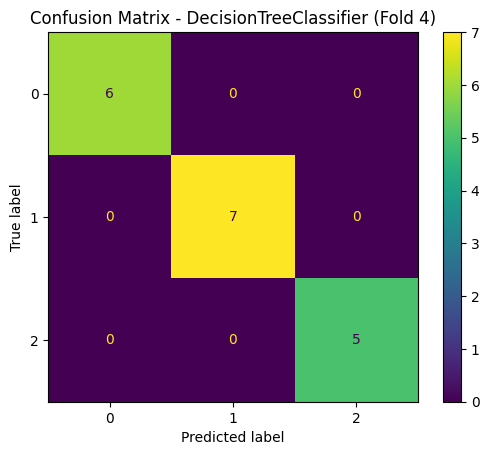


Validation F1 score for fold 5: 0.8888886995563674
Best hyperparameters for fold 5: OrderedDict([('classification__ccp_alpha', 0.0), ('classification__criterion', 'entropy')])
Test F1 score for fold 5: 1.0



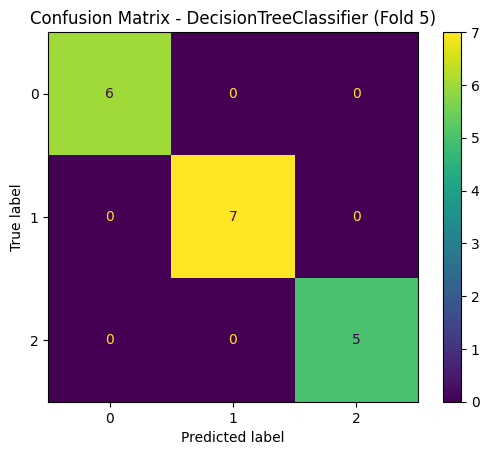


Validation F1 score for fold 6: 0.8774493944896111
Best hyperparameters for fold 6: OrderedDict([('classification__ccp_alpha', 0.016853932584269662), ('classification__criterion', 'gini')])
Test F1 score for fold 6: 0.9440559440559441



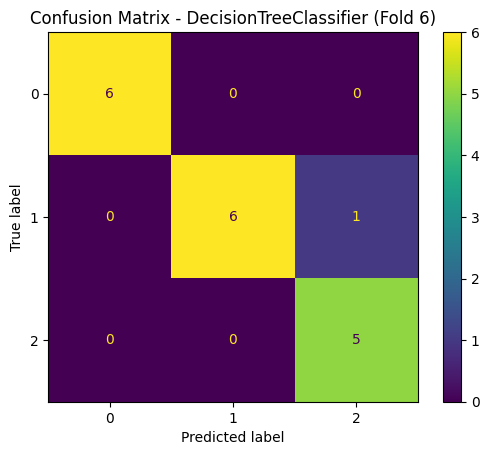


Validation F1 score for fold 7: 0.8751695079223684
Best hyperparameters for fold 7: OrderedDict([('classification__ccp_alpha', 0.06105020507820828), ('classification__criterion', 'entropy')])
Test F1 score for fold 7: 0.9474747474747475



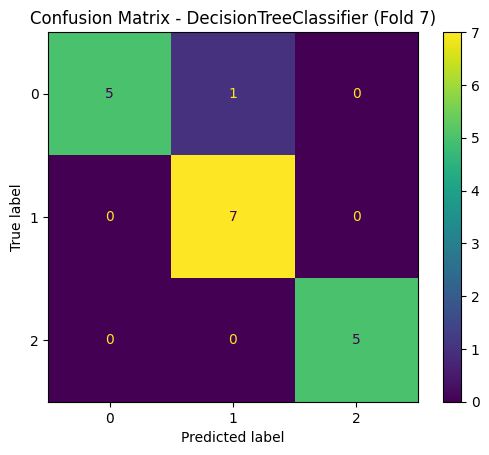


Validation F1 score for fold 8: 0.9213629246570424
Best hyperparameters for fold 8: OrderedDict([('classification__ccp_alpha', 0.02171015044753381), ('classification__criterion', 'entropy')])
Test F1 score for fold 8: 0.8363636363636364



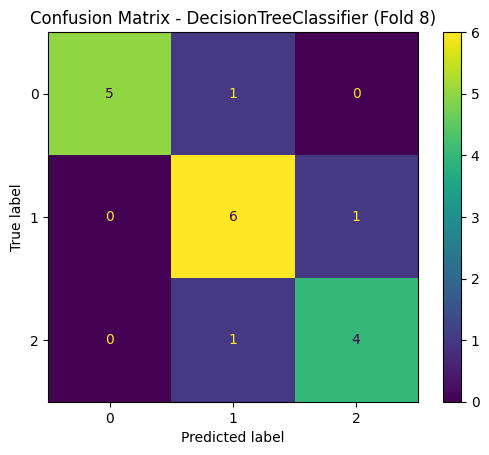


Validation F1 score for fold 9: 0.8993209650346097
Best hyperparameters for fold 9: OrderedDict([('classification__ccp_alpha', 0.02171015044753381), ('classification__criterion', 'entropy')])
Test F1 score for fold 9: 0.9373219373219372



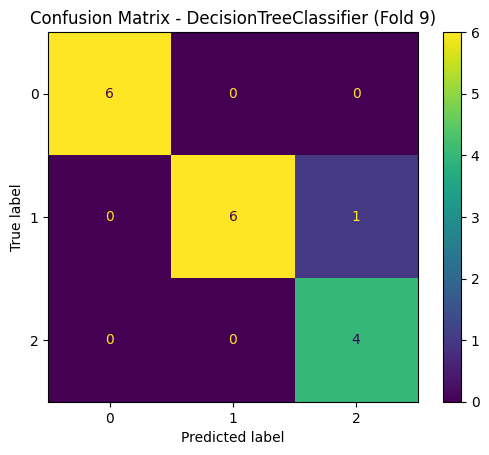


Validation F1 score for fold 10: 0.9201772215235484
Best hyperparameters for fold 10: OrderedDict([('classification__ccp_alpha', 0.010879258070269298), ('classification__criterion', 'entropy')])
Test F1 score for fold 10: 0.9474747474747475



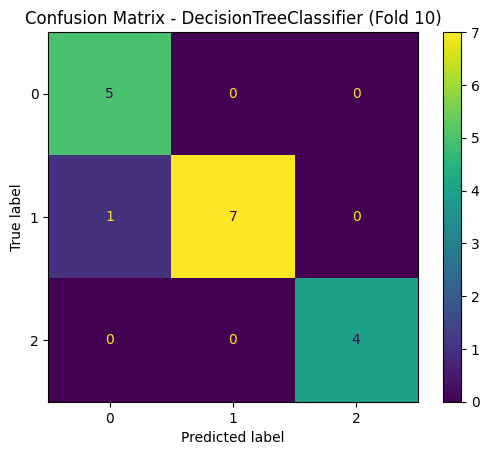


----------------------
Average validation F1 score: 0.9030066940363805
Average test F1 score: 0.9494172494172493


In [12]:
clf = DecisionTreeClassifier(random_state=120, class_weight='balanced')
pipeline = Pipeline(steps=[])
pipeline.steps.append(('classification',clf))
search_space = dict()
search_space['classification__ccp_alpha'] = Categorical(ccp_alphas)
search_space['classification__criterion'] = Categorical(['gini','entropy'])
nested_cv(X, y, pipeline, search_space)

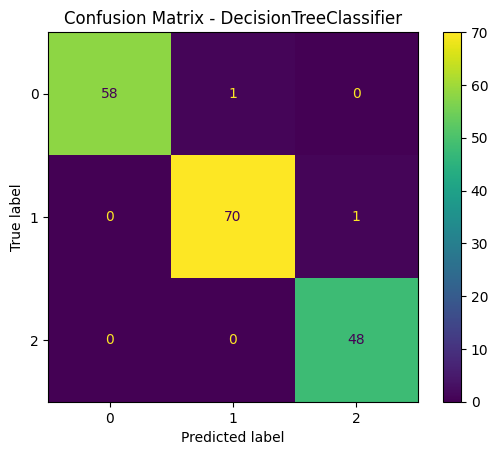

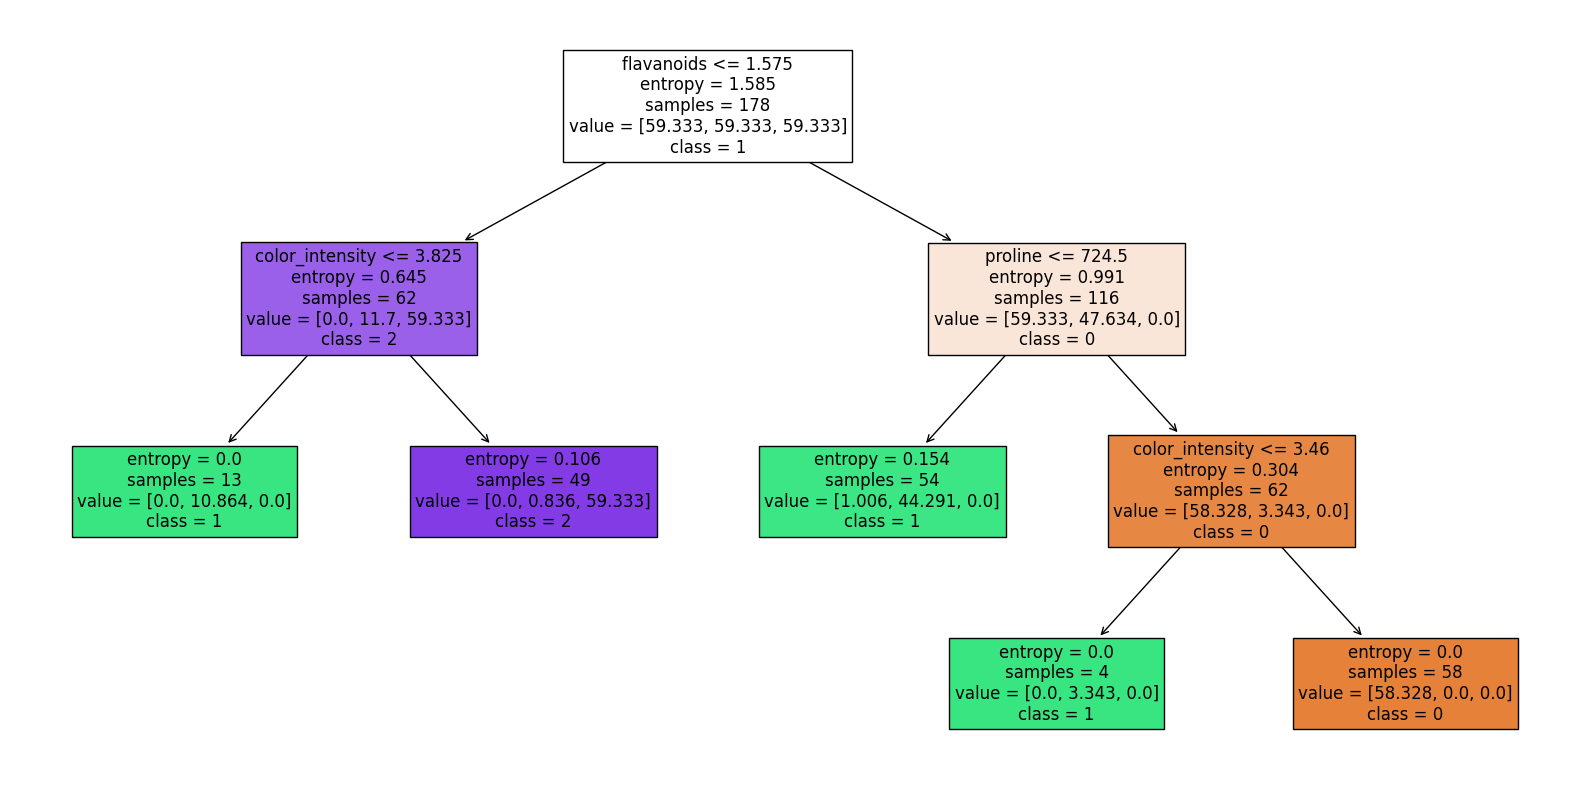

In [13]:
search = BayesSearchCV(estimator=pipeline, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - DecisionTreeClassifier")
plt.grid(False)
plt.show()
plt.figure(figsize=(16,8))
features = X.columns
classes = ['0','1','2']
tree.plot_tree(search.best_estimator_[-1],feature_names=features,class_names = classes, filled=True,max_depth=3, fontsize=12)
plt.tight_layout()
plt.show()